https://www.kaggle.com/code/prakharprasad/time-series-vector-autoregression/notebook

## Vector Auto Regression

Importing necessary libs for the project 

In [1]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

## Import, Load and Inspect the Dataset 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#read the data
df = pd.read_excel("hexano.xlsx")

#check the dtypes
df.dtypes

Date        datetime64[ns]
FOB                float64
CIF                float64
Brent              float64
Barril             float64
tonelada           float64
Dolar              float64
dtype: object

Making the first column as an index with the format of Date.
Also, using dropna() to elminate empty cells

In [3]:
df['Date'] = pd.to_datetime(df.Date , format = '%m/%d/%Y')
data = df.drop(['Date'], axis=1)
data.index = df.Date
data

,FOB,CIF,Brent,Barril,tonelada,Dolar
Date,,,,,,
2014-01-01,3.402300,3.908300,107.040000,254.990688,1002.17,2.3661
2014-02-01,3.025800,3.481500,108.200000,257.916340,984.17,2.4011
2014-03-01,2.961000,3.416700,107.720000,250.567492,987.50,2.3402
2014-04-01,2.896100,3.351900,108.170000,241.521976,993.48,2.2475
2014-05-01,NaN,NaN,109.063200,242.218461,NaN,NaN
...,...,...,...,...,...,...
2021-06-01,5.914683,6.509612,73.258636,368.630497,762.17,5.1016
2021-07-01,6.297107,6.892902,74.116665,382.197777,807.14,5.1220
2021-08-01,6.297788,6.892902,70.427884,369.867386,804.77,5.2357


In [35]:
data1 = data.dropna()
data1.head(12)
data2 = data.drop(data.index[range(5)])
data2.head()

,FOB,CIF,Brent,Barril,tonelada,Dolar
Date,,,,,,
2014-06-01,2.9541,3.4098,111.8229,249.980093,993.48,2.2475
2014-07-01,3.0150,3.4707,108.5683,241.521040,1021.68,2.2173
2014-08-01,2.9336,3.3893,103.4071,234.527303,952.05,2.2630
2014-09-01,2.9152,3.3709,99.2482,231.536126,928.70,2.2993
2014-10-01,2.8521,3.3079,88.2530,216.069820,830.68,2.4428


Plot the Source Data

<AxesSubplot:xlabel='Date'>

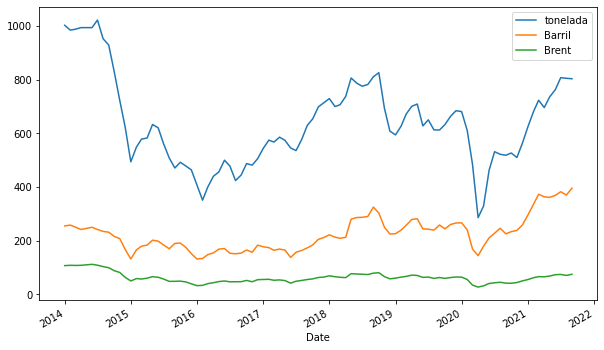

In [5]:
data1[['tonelada', 'Barril', 'Brent']].plot(figsize=(10,6))


## Creating a function Dickey Fuller to check the stationarity of the Time Series 

In [6]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')
    
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [36]:
dickey_fuller(data2['FOB'],title='FOB')

Augmented Dickey Fuller Test for the dataset FOB
ADF test statistics      0.171445
p-value                  0.970614
#lags                    3.000000
#observations           84.000000
critical value (1%)     -3.510712
critical value (5%)     -2.896616
critical value (10%)    -2.585482
Weak evidence against the Null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


In [37]:
dickey_fuller(data2['tonelada'],title='tonelada')

Augmented Dickey Fuller Test for the dataset tonelada
ADF test statistics     -2.908699
p-value                  0.044346
#lags                    2.000000
#observations           85.000000
critical value (1%)     -3.509736
critical value (5%)     -2.896195
critical value (10%)    -2.585258
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary




So both the FOB and the tonelada is non stationary. 
We will take the first order difference of the entire dataframe and re-run the dickey fuller test and store it in a separate dataframe so that the original dataframe is retained.


In [38]:
data2_diff = data2.diff() # by default, diff performs the first order difference
data2_diff 

,FOB,CIF,Brent,Barril,tonelada,Dolar
Date,,,,,,
2014-06-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-01,0.060900,0.060900,-3.254600,-8.459053,28.20,-0.0302
2014-08-01,-0.081400,-0.081400,-5.161200,-6.993737,-69.63,0.0457
2014-09-01,-0.018400,-0.018400,-4.158900,-2.991177,-23.35,0.0363
2014-10-01,-0.063100,-0.063000,-10.995200,-15.466306,-98.02,0.1435
...,...,...,...,...,...,...
2021-06-01,-0.211229,-0.211088,4.999112,7.465465,26.46,-0.2225
2021-07-01,0.382424,0.383289,0.858029,13.567280,44.97,0.0204
2021-08-01,0.000681,0.000000,-3.688781,-12.330391,-2.37,0.1137


In [39]:
data2_diff = data2_diff.dropna()
data2_diff 

,FOB,CIF,Brent,Barril,tonelada,Dolar
Date,,,,,,
2014-07-01,0.060900,0.060900,-3.254600,-8.459053,28.20,-0.0302
2014-08-01,-0.081400,-0.081400,-5.161200,-6.993737,-69.63,0.0457
2014-09-01,-0.018400,-0.018400,-4.158900,-2.991177,-23.35,0.0363
2014-10-01,-0.063100,-0.063000,-10.995200,-15.466306,-98.02,0.1435
2014-11-01,-0.192000,-0.192100,-6.803200,-8.503150,-108.54,0.0895
...,...,...,...,...,...,...
2021-05-01,0.054579,0.121345,2.930476,-2.203952,40.03,-0.3154
2021-06-01,-0.211229,-0.211088,4.999112,7.465465,26.46,-0.2225
2021-07-01,0.382424,0.383289,0.858029,13.567280,44.97,0.0204


In [40]:
dickey_fuller(data2_diff['FOB'],title='FOB 1st Order Diff')

Augmented Dickey Fuller Test for the dataset FOB 1st Order Diff
ADF test statistics    -6.660137e+00
p-value                 4.870579e-09
#lags                   2.000000e+00
#observations           8.400000e+01
critical value (1%)    -3.510712e+00
critical value (5%)    -2.896616e+00
critical value (10%)   -2.585482e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [41]:
dickey_fuller(data2_diff['tonelada'],title='tonelada 1st Order Diff')

Augmented Dickey Fuller Test for the dataset tonelada 1st Order Diff
ADF test statistics    -6.074996e+00
p-value                 1.127138e-07
#lags                   1.000000e+00
#observations           8.500000e+01
critical value (1%)    -3.509736e+00
critical value (5%)    -2.896195e+00
critical value (10%)   -2.585258e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary



Now, both features( FOB and tonelada) are stationary. 
Hence we are good to go with the remaining steps of training, test predictions and finally forecasting into the future.


In [42]:

# check the length of the transformed df -- > should be 2 rows lesser than the original
len(data2_diff)

87

## Train Test Split

In [43]:
nobs = 12
train = data2_diff[:-nobs]
test = data2_diff[-nobs:]


In [44]:
len(train), len(test)

(75, 12)


# VAR Model Order Selection

## VAR(p) of order p

So far in my other notebooks on time series on ARIMA and SARIMA, I used the auto_arima from pmdarima library. 
That method won't work here to determine the order of the VAR model. 

I will test this manually with a list of order p values and select the p value which returns the minimum AIC or BIC metric. 

Check Akaike Information Criterion and Bayesian Information Criterion for more details.


In [45]:
p = [1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(train)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print()

VAR Order 1
AIC -1.9680169329369517
BIC -0.6603043124697199

VAR Order 2
AIC -1.6472669344008972
BIC 0.800073290387795

VAR Order 3
AIC -1.116559193957546
BIC 2.488162161151209

VAR Order 4
AIC -0.8399695339406206
BIC 3.9403400654424408

VAR Order 5
AIC -0.7635521318973044
BIC 5.21102093983385

VAR Order 6
AIC -0.8670107440873167
BIC 6.3209840967908235

VAR Order 7
AIC -1.158830774966619
BIC 7.262242577025081



/home/cristian/anaconda3/envs/teste/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cristian/anaconda3/envs/teste/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cristian/anaconda3/envs/teste/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cristian/anaconda3/envs/teste/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/cristian/anaconda3/envs/teste/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mod

In [46]:
# Order 1 has the least AIC value. Lets select p = 1 in the modeling
# lets confirm the variables are included in the model
model.endog_names


['FOB', 'CIF', 'Brent', 'Barril', 'tonelada', 'Dolar']

## Fit the VAR(1) model

In [47]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Mar, 2022
Time:                     14:40:13
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    5.21102
Nobs:                     70.0000    HQIC:                   1.60962
Log likelihood:          -383.230    FPE:                   0.691782
AIC:                    -0.763552    Det(Omega_mle):       0.0766707
--------------------------------------------------------------------
Results for equation FOB
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.007747         0.037298            0.208           0.835
L1.FOB             -2.875135         1.586882           -1.812           0.070
L1.CIF              2.904602         1.599760            1.816        


##  Predict the next 12 values

For predictions, VAR model uses .forecast() instead of predictions. This is similar to the Holt Winters. 

One of the requirement for VAR model is that we need to pass the lag order of the number of previous observations as well. 

Unfortunately, this lag order does not have the datetime index and hence we will have to build this ourselves.


In [48]:
lag_order = results.k_ar
lag_order


5

In [49]:
z = results.forecast(y=train.values[-lag_order:],steps = 12)
z


array([[-2.89372181e-01, -2.44232038e-01, -7.99459529e+00,
        -1.39447555e+01, -6.45175865e+01, -3.16659510e-01],
       [-6.49077073e-01, -6.92032496e-01, -1.40558182e+01,
        -5.47468003e+01, -9.31290852e+01,  4.31881843e-01],
       [-5.92687346e-02, -4.31869335e-02,  4.24430507e+00,
         2.13178249e+01, -5.40687829e+01,  2.38038945e-02],
       [ 3.42505170e-01,  3.28672914e-01,  1.73839924e+00,
         8.68107580e+00,  5.00430318e+01,  2.57609173e-01],
       [ 4.81925851e-01,  4.63904889e-01,  2.00657728e+00,
         1.32975774e+01,  5.08009769e+01, -2.63703935e-01],
       [-3.23226744e-01, -3.14918704e-01,  1.62313989e+00,
        -4.62470344e+00,  2.32238456e+00,  2.90363784e-01],
       [ 5.49621217e-01,  5.45277812e-01,  5.02390685e+00,
         3.58667548e+01,  2.30112398e+01, -1.30122537e-02],
       [-1.44659948e-01, -1.23850941e-01, -5.96990375e+00,
        -3.23343013e+01, -4.15190701e+00,  4.36932058e-02],
       [-1.20890625e-01, -1.10958001e-01, -2.546

In [50]:
test

,FOB,CIF,Brent,Barril,tonelada,Dolar
Date,,,,,,
2020-10-01,0.220000,0.219957,-0.265791,7.956458,8.27,0.2081
2020-11-01,-0.234900,-0.234939,2.474016,4.773699,-16.66,-0.0977
2020-12-01,0.004139,0.004176,6.148762,19.667129,52.28,-0.3339
2021-01-01,0.597475,0.597475,5.065366,37.690134,62.47,0.1342
2021-02-01,0.668390,0.668390,6.831976,40.330381,56.57,0.1100
2021-03-01,0.203462,0.186727,4.004522,36.853269,41.91,0.1980
2021-04-01,-0.275933,-0.276762,-0.695493,-9.415346,-27.32,0.0278
2021-05-01,0.054579,0.121345,2.930476,-2.203952,40.03,-0.3154
2021-06-01,-0.211229,-0.211088,4.999112,7.465465,26.46,-0.2225


In [51]:
idx = pd.date_range(start='10/1/2020',periods=12,freq='MS')
df_forecast = pd.DataFrame(z,index=idx,columns=['FOB', 'CIF', 'Brent', 'Barril', 'tonelada', 'Dolar'])

In [52]:
df_forecast[:5]

,FOB,CIF,Brent,Barril,tonelada,Dolar
2020-10-01,-0.289372,-0.244232,-7.994595,-13.944756,-64.517587,-0.316660
2020-11-01,-0.649077,-0.692032,-14.055818,-54.746800,-93.129085,0.431882
2020-12-01,-0.059269,-0.043187,4.244305,21.317825,-54.068783,0.023804
2021-01-01,0.342505,0.328673,1.738399,8.681076,50.043032,0.257609
2021-02-01,0.481926,0.463905,2.006577,13.297577,50.800977,-0.263704



## Invert the Transformations

The forecasted values represent the 2nd order difference forecast. To compare them to the original data we have to roll back each difference. 
To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values.
When working with second-order differences we first must perform this operation on the most recent first-order difference.


In [53]:
# Now build the forecast values from the first difference set
df_forecast['FOBForecast'] = df['FOB'].iloc[-nobs-1] + df_forecast['FOB'].cumsum()


In [54]:
df_forecast

,FOB,CIF,Brent,Barril,tonelada,Dolar,FOBForecast
2020-10-01,-0.289372,-0.244232,-7.994595,-13.944756,-64.517587,-0.316660,4.819328
2020-11-01,-0.649077,-0.692032,-14.055818,-54.746800,-93.129085,0.431882,4.170251
2020-12-01,-0.059269,-0.043187,4.244305,21.317825,-54.068783,0.023804,4.110982
2021-01-01,0.342505,0.328673,1.738399,8.681076,50.043032,0.257609,4.453487
2021-02-01,0.481926,0.463905,2.006577,13.297577,50.800977,-0.263704,4.935413
2021-03-01,-0.323227,-0.314919,1.623140,-4.624703,2.322385,0.290364,4.612186
2021-04-01,0.549621,0.545278,5.023907,35.866755,23.011240,-0.013012,5.161808
2021-05-01,-0.144660,-0.123851,-5.969904,-32.334301,-4.151907,0.043693,5.017148
2021-06-01,-0.120891,-0.110958,-0.254661,9.535636,-31.601866,-0.245956,4.896257
2021-07-01,-0.402095,-0.405854,-9.305010,-36.950797,-54.870894,0.385664,4.494161


In [55]:
df_forecast['toneladaForecast'] = df['tonelada'].iloc[-nobs-1] + df_forecast['tonelada'].cumsum()
df_forecast

,FOB,CIF,Brent,Barril,tonelada,Dolar,FOBForecast,toneladaForecast
2020-10-01,-0.289372,-0.244232,-7.994595,-13.944756,-64.517587,-0.316660,4.819328,461.912413
2020-11-01,-0.649077,-0.692032,-14.055818,-54.746800,-93.129085,0.431882,4.170251,368.783328
2020-12-01,-0.059269,-0.043187,4.244305,21.317825,-54.068783,0.023804,4.110982,314.714545
2021-01-01,0.342505,0.328673,1.738399,8.681076,50.043032,0.257609,4.453487,364.757577
2021-02-01,0.481926,0.463905,2.006577,13.297577,50.800977,-0.263704,4.935413,415.558554
2021-03-01,-0.323227,-0.314919,1.623140,-4.624703,2.322385,0.290364,4.612186,417.880939
2021-04-01,0.549621,0.545278,5.023907,35.866755,23.011240,-0.013012,5.161808,440.892178
2021-05-01,-0.144660,-0.123851,-5.969904,-32.334301,-4.151907,0.043693,5.017148,436.740271
2021-06-01,-0.120891,-0.110958,-0.254661,9.535636,-31.601866,-0.245956,4.896257,405.138405
2021-07-01,-0.402095,-0.405854,-9.305010,-36.950797,-54.870894,0.385664,4.494161,350.267512


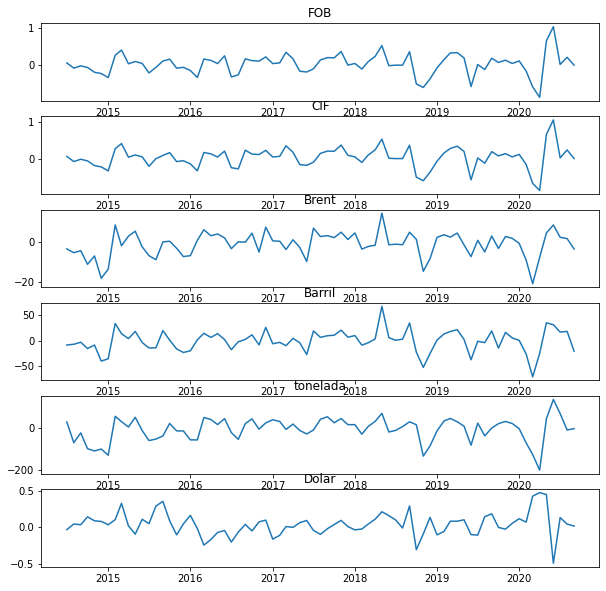

In [56]:
# Plotting the results

results.plot();



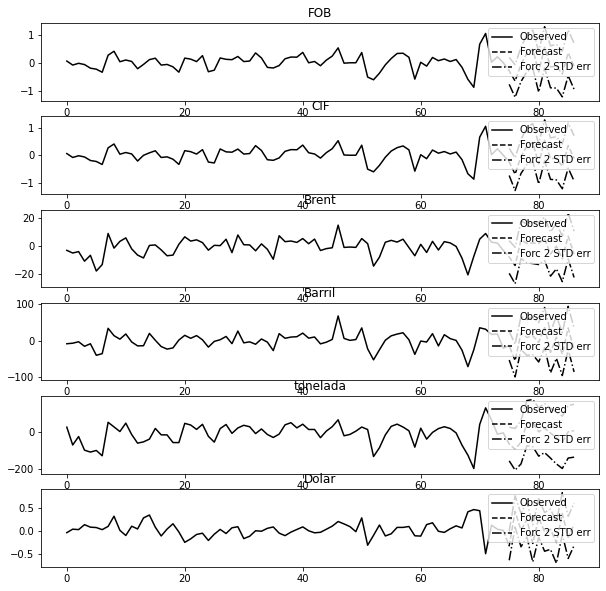

In [57]:
results.plot_forecast(12);

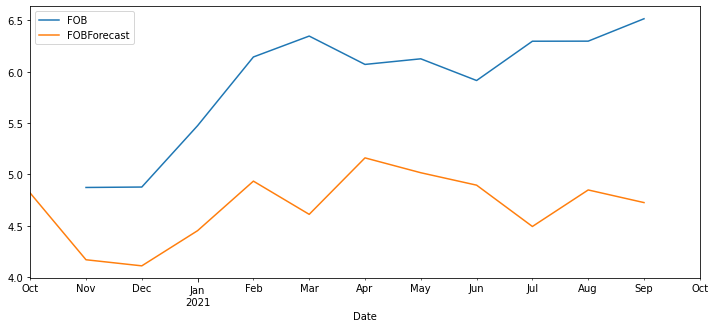

In [58]:
data2['FOB'][-nobs:].plot(figsize=(12,5),legend=True)
df_forecast['FOBForecast'].plot(legend=True);



## Model Evaluation

In [30]:
RMSE1 = rmse(data1['FOB'][-nobs:], df_forecast['FOBForecast'])
print(f'FOB VAR(5) RMSE: {RMSE1:.3f}')


FOB VAR(5) RMSE: 1.259


In [31]:
RMSE2 = rmse(data1['tonelada'][-nobs:], df_forecast['toneladaForecast'])
print(f'tonelada VAR(5) RMSE: {RMSE2:.3f}')

tonelada VAR(5) RMSE: 333.436


In [32]:
Fonte: https://www.kaggle.com/code/prakharprasad/time-series-vector-autoregression


SyntaxError: invalid syntax (2035810171.py, line 1)